## Data Exploration: Training Data
In this notebook, we'll do some basic exploration and visualisation of the training data file to get a better domain understanding. This will include linking to lookup data.

This notebook requires that train.csv (or smaller_train.csv) and town_state.csv, producto_tabla.csv, cliente_tabla.csv are located in '../data'.

Some sections can take up to 10 minutes to run on local workstation (i7, 8GB) with the larger training file

In [8]:
# Imports go here
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.tools.plotting import scatter_matrix

# specify a data file path
data_location = "../data/"

### Getting Started
We'll load the large training file, produce basic statistics, look at data

In [9]:
# let's now take in the training data file and do some basic stats (160s)
# train_file = "smaller_train.csv"
train_file = "train.csv"

# specify columns for the training data as spanish is not a strong point in London
train_columns = ['WeekNumber','AgencyId','ChannelId','RouteId','ClientId','ProductId','Sales',
                 'SalesPesos','Returns','ReturnsPesos','Demand']

# load the training data in full, skip the column headings on the first rows and time how long it takes
t0 = time.time()
df_train = pd.read_csv(data_location + train_file,names=train_columns,skiprows=1)
t1 = time.time()
total_time = t1-t0
# print the memory usage and top line statistics
print "Total record count for is {}, taking {} bytes of memory, loaded in {} seconds".format(len(df_train),
                                                                                             df_train.memory_usage().sum(),
                                                                                             total_time)

# first 5 lines
print df_train.head(5)

Total record count for is 74180464, taking 6527880904 bytes of memory, loaded in 162.539999962 seconds
   WeekNumber  AgencyId  ChannelId  RouteId  ClientId  ProductId  Sales  \
0           3      1110          7     3301     15766       1212      3   
1           3      1110          7     3301     15766       1216      4   
2           3      1110          7     3301     15766       1238      4   
3           3      1110          7     3301     15766       1240      4   
4           3      1110          7     3301     15766       1242      3   

   SalesPesos  Returns  ReturnsPesos  Demand  
0       25.14        0           0.0       3  
1       33.52        0           0.0       4  
2       39.32        0           0.0       4  
3       33.52        0           0.0       4  
4       22.92        0           0.0       3  


### First Impressions
We can see that there are a lot of training records...more than the workstation will handle so we will need to reduce the data for initial training...that's for later, though.

There are 5 numeric attributes: 
+ Sales (units sold) and SalesPesos (monetary value of sales), 
+ Returns (units returned) and ReturnsPesos (monetary value of returns)
+ Demand (Sales - Returns) 

There are 5 categorical attributes:
+ with lookups: AgencyId (something like a distributor), ClientId (retailer), ProductId (unit being sold)
+ without lookups: ChannelId and RouteId (no domain knowledge available to describe what these are)
    
Finally, there is the WeekNumber, which is the week for the entry

To make use of the data in a machine learning sense, we will need to transpose data which is by week into columns - for example use week 3 data as a lag feature for week 4 keyed on the 5 categorical attributes. More on this later.

We'll now create some visualisations and summary statistics

In [10]:
# looking at counting unique categories
print 'Clients: ', df_train['ClientId'].value_counts().shape
print 'Products: ',df_train['ProductId'].value_counts().shape
print 'Routes: ',df_train['RouteId'].value_counts().shape
print 'Channels: ',df_train['ChannelId'].value_counts().shape
print 'Agencies: ',df_train['AgencyId'].value_counts().shape

Clients:  (880604L,)
Products:  (1799L,)
Routes:  (3603L,)
Channels:  (9L,)
Agencies:  (552L,)


In [11]:
# looking at summary statistics for numeric (75s)
t0 = time.time()
stats = df_train[['Sales','SalesPesos','Returns','ReturnsPesos','Demand']].describe(percentiles=[0.25,0.5,0.75,0.99])
print stats
print "that took: ", time.time() - t0, " seconds."

              Sales    SalesPesos       Returns  ReturnsPesos        Demand
count  7.418046e+07  7.418046e+07  7.418046e+07  7.418046e+07  7.418046e+07
mean   7.310163e+00  6.854452e+01  1.302577e-01  1.243248e+00  7.224564e+00
std    2.196734e+01  3.389795e+02  2.932320e+01  3.921552e+01  2.177119e+01
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    2.000000e+00  1.676000e+01  0.000000e+00  0.000000e+00  2.000000e+00
50%    3.000000e+00  3.000000e+01  0.000000e+00  0.000000e+00  3.000000e+00
75%    7.000000e+00  5.610000e+01  0.000000e+00  0.000000e+00  6.000000e+00
99%    6.500000e+01  6.531700e+02  3.000000e+00  2.514000e+01  6.400000e+01
max    7.200000e+03  6.473600e+05  2.500000e+05  1.307600e+05  5.000000e+03
that took:  83.4970002174  seconds.


That took:  34.6619999409  seconds


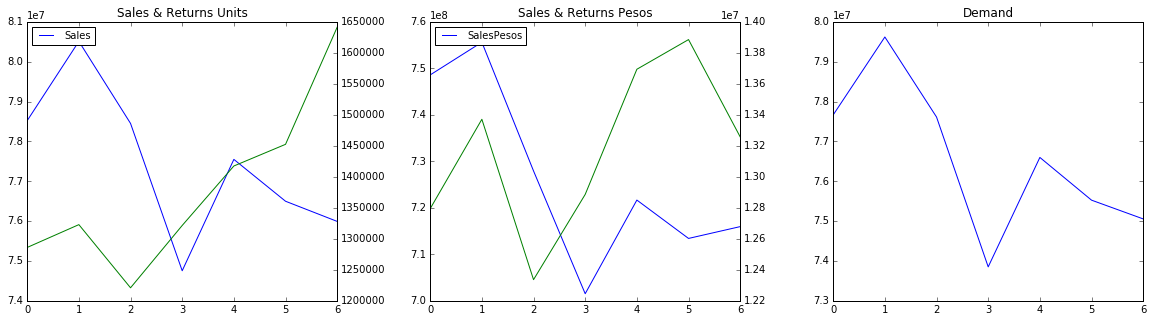

In [12]:
# let's look at each numeric attribute by week to examine relationships over time (30s)
t0 = time.time()
df_summary = df_train.groupby(by='WeekNumber',as_index=False)['Sales','Returns','Demand','SalesPesos','ReturnsPesos'].sum()

# plot the graphs...
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))

df_summary['Sales'].plot(ax=axes[0],title='Sales & Returns Units',x='WeekNumber',use_index=False)
df_summary['Returns'].plot(ax=axes[0],x='WeekNumber',secondary_y='Returns',use_index=False)
axes[0].legend(loc=2,prop={'size':10})

df_summary['SalesPesos'].plot(ax=axes[1],title='Sales & Returns Pesos',x='WeekNumber',use_index=False)
df_summary['ReturnsPesos'].plot(ax=axes[1],x='WeekNumber',secondary_y='ReturnsPesos',use_index=False)
axes[1].legend(loc=2,prop={'size':10})

df_summary['Demand'].plot(ax=axes[2],title='Demand',x='WeekNumber',use_index=False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0.3, hspace=None)

t1 = time.time()
print "That took: ", t1-t0, " seconds"

that took:  853.247999907  seconds


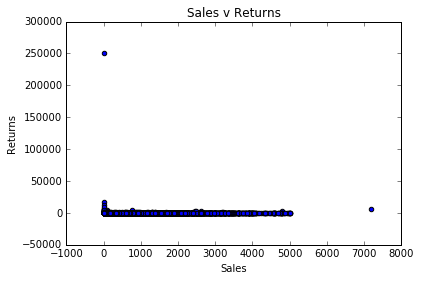

In [13]:
# let's look at Sales v Returns (800 to 1000s)
t0 = time.time()
df_train.plot.scatter(x='Sales',y='Returns',title='Sales v Returns',sharex=False)
print 'that took: ', time.time()-t0, ' seconds'

datset created in:  51.6119999886  seconds
Sales correlation to last week:  0.885025846824
Returns correlation to last week:  0.682095517858
Returns correlation to last week Sales:  0.0688074216364
Sales correlation to last week Returns:  0.0596466833508
Returns proportion of Sales:  0.021599345718
Last week Returns proportion of last week Sales:  0.0189857547328
that all took:  965.815000057  seconds


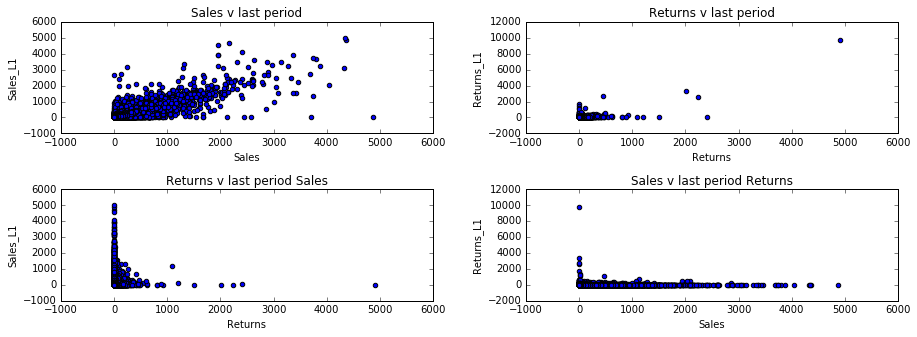

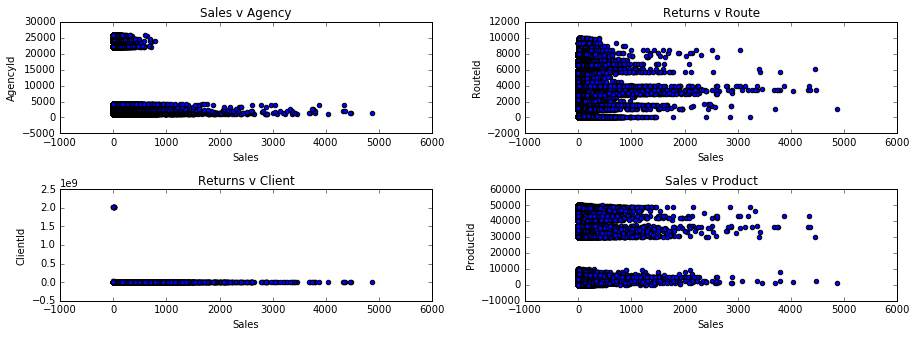

In [14]:
# let's look at lagged sales correlation between weeks 9 and 8 (1000s)
t0 = time.time()

# hive off week 9 to a separate data frame
df_week_9 = df_train[df_train['WeekNumber']==9]
df_week_9 = df_week_9.drop('WeekNumber',axis=1)
filter_9 = ['AgencyId','ChannelId','RouteId','ClientId','ProductId','Sales','SalesPesos','Returns',
                'ReturnsPesos','Demand']
df_week_9.columns = filter_9

# hive off week 8 to a separate data frame
df_week_8 = df_train[df_train['WeekNumber']==8]
df_week_8 = df_week_8.drop('WeekNumber',axis=1)
filter_8 = ['AgencyId','ChannelId','RouteId','ClientId','ProductId','Sales_L1','SalesPesos_L1','Returns_L1',
                'ReturnsPesos_L1','Demand_L1']
df_week_8.columns = filter_8

# join week 8 and 9 on the Ids
join_keys = ['AgencyId','ChannelId','RouteId','ClientId','ProductId']
df = pd.merge(df_week_9, df_week_8, how='outer', on=join_keys)

print 'datset created in: ',time.time()-t0,' seconds'

# display a correlation graph
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,5))
df.plot.scatter(ax=axes[0,0],x='Sales',y='Sales_L1',sharex=False,title='Sales v last period')
df.plot.scatter(ax=axes[0,1],x='Returns',y='Returns_L1',sharex=False,title='Returns v last period')
df.plot.scatter(ax=axes[1,0],x='Returns',y='Sales_L1',sharex=False,title='Returns v last period Sales')
df.plot.scatter(ax=axes[1,1],x='Sales',y='Returns_L1',sharex=False,title='Sales v last period Returns')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0.25, hspace=0.5)

# print the correleation coefficients
print 'Sales correlation to last week: ', df['Sales'].corr(df['Sales_L1'],method='pearson')
print 'Returns correlation to last week: ', df['Returns'].corr(df['Returns_L1'],method='pearson')
print 'Returns correlation to last week Sales: ', df['Returns'].corr(df['Sales_L1'],method='pearson')
print 'Sales correlation to last week Returns: ', df['Sales'].corr(df['Returns_L1'],method='pearson')

# show the ratio of returns to sales
print 'Returns proportion of Sales: ', np.sum(df['Returns'])/np.sum(df['Sales'])
print 'Last week Returns proportion of last week Sales: ', np.sum(df['Returns_L1'])/np.sum(df['Sales_L1'])

# show the relationship of week 9 sales to each attribute
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,5))
df.plot.scatter(ax=axes[0,0],x='Sales',y='AgencyId',sharex=False,title='Sales v Agency')
df.plot.scatter(ax=axes[0,1],x='Sales',y='RouteId',sharex=False,title='Returns v Route')
df.plot.scatter(ax=axes[1,0],x='Sales',y='ClientId',sharex=False,title='Returns v Client')
df.plot.scatter(ax=axes[1,1],x='Sales',y='ProductId',sharex=False,title='Sales v Product')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0.25, hspace=0.5)

print 'that all took: ',time.time()-t0,' seconds'

### Insight into numeric values
Sales and Returns have very different scales (as do SalesPesos and ReturnsPesos). 99% of transactions are 'small' or clustered around a low range of values but 1% of the transactions are very large which means there is a left-skewed distribution of values. There is little variation in weekly transactions. There looks to be 1 very large and anomalous return for 250,000 units and 1 large sale of 7000 units. The large return looks very odd as no other entry exists for that client and product pair. perhaps a data entry error.

Let's look at categorical associations

#### Product

In [9]:
# grouping of product data and sorting by count in descending order by Sales (50s)
t0 = time.time()
df_summary = df_train.groupby(by='ProductId',as_index=False)['Sales','SalesPesos','Returns','ReturnsPesos','Demand'].sum()

# show statistics
stats = df_summary.describe(percentiles=[0.25,0.5,0.75,0.99])
print stats
print time.time() - t0

          ProductId         Sales    SalesPesos        Returns  ReturnsPesos  \
count   1799.000000  1.799000e+03  1.799000e+03    1799.000000  1.799000e+03   
mean   32621.697054  3.014293e+05  2.826384e+06    5371.080600  5.126443e+04   
std    13571.296980  1.360251e+06  1.100143e+07   19743.053116  1.783320e+05   
min       41.000000  0.000000e+00  0.000000e+00       0.000000  0.000000e+00   
25%    31549.500000  6.910000e+02  9.902140e+03      10.000000  1.348150e+02   
50%    35516.000000  9.138000e+03  1.297101e+05     223.000000  2.953800e+03   
75%    42787.000000  9.643500e+04  1.152423e+06    2151.500000  2.416018e+04   
99%    49779.040000  6.471917e+06  5.353397e+07   90438.320000  8.352640e+05   
max    49997.000000  2.386031e+07  2.229872e+08  297745.000000  2.966597e+06   

             Demand  
count  1.799000e+03  
mean   2.978997e+05  
std    1.349053e+06  
min    0.000000e+00  
25%    6.205000e+02  
50%    8.842000e+03  
75%    9.493450e+04  
99%    6.433945e+06  
m

16.1840000153


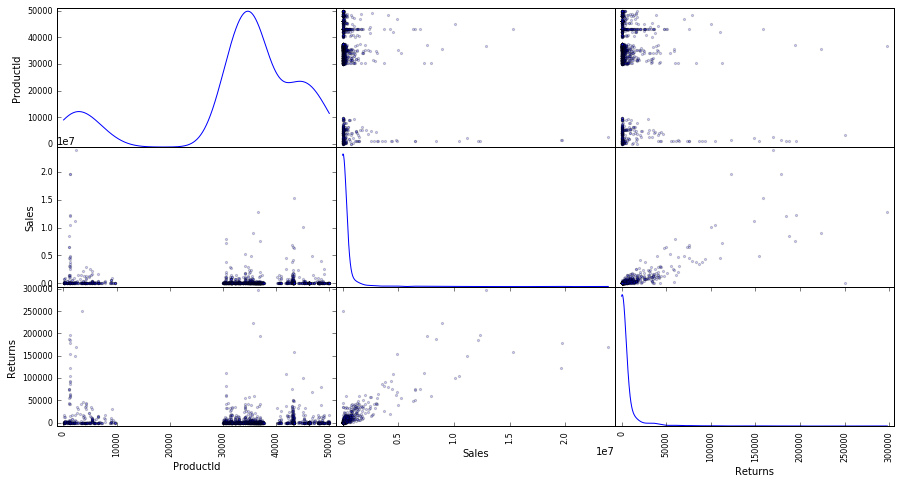

In [10]:
# graph how sales and returns are distributed across product (9s)
t0 = time.time()

# do a scatter matrix plot for the numerics
scatter_matrix(df_summary[['ProductId','Sales','Returns']],alpha=0.2,diagonal='kde',figsize=(15,7.5))
print time.time() - t0

#### Channel

In [11]:
## grouping of channel data and sorting by count in descending order by Sales (25s)
t0 = time.time()
df_summary = df_train.groupby(by='ChannelId',as_index=False)['Sales','SalesPesos','Returns','ReturnsPesos','Demand'].sum()
df_summary = df_summary.sort_values(by='Sales',ascending=False)

# show statistics
stats = df_summary.describe(percentiles=[0.25,0.5,0.75,0.99])
print stats
print time.time() - t0

       ChannelId         Sales    SalesPesos       Returns  ReturnsPesos  \
count   9.000000  9.000000e+00  9.000000e+00  9.000000e+00  9.000000e+00   
mean    5.888889  6.025237e+07  5.649627e+08  1.073619e+06  1.024719e+07   
std     3.257470  1.253577e+08  1.011810e+09  1.978009e+06  1.777446e+07   
min     1.000000  3.349700e+04  1.533784e+06  0.000000e+00  0.000000e+00   
25%     4.000000  3.569312e+06  4.158925e+07  1.328170e+05  1.588764e+06   
50%     6.000000  1.466154e+07  1.658751e+08  2.520790e+05  2.379443e+06   
75%     8.000000  4.666325e+07  4.710039e+08  1.226250e+06  9.170592e+06   
99%    10.840000  3.636889e+08  2.967429e+09  5.791036e+06  5.180279e+07   
max    11.000000  3.907573e+08  3.143720e+09  6.177725e+06  5.458890e+07   

             Demand  
count  9.000000e+00  
mean   5.954683e+07  
std    1.240558e+08  
min    3.349700e+04  
25%    3.549277e+06  
50%    1.458958e+07  
75%    4.646811e+07  
99%    3.598256e+08  
max    3.866466e+08  
27.8459999561


0.233999967575


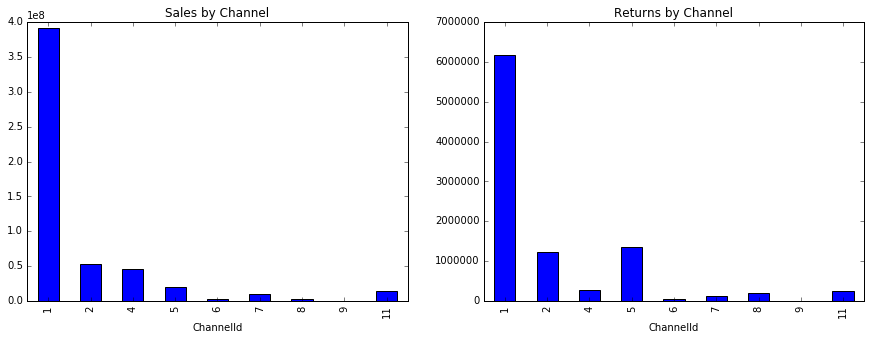

In [12]:
t0 = time.time()
df_summary = df_summary.sort_values(by='ChannelId')
# plot a bar chart for sales and return
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(15,5))
df_summary.plot(kind='bar',ax=axes[0],x='ChannelId',y='Sales',sharex=False,title='Sales by Channel', legend=False)
df_summary.plot(kind='bar',ax=axes[1],x='ChannelId',y='Returns',sharex=False,title='Returns by Channel', legend=False)
print time.time() - t0

#### Product v Channel
1 channel (number 1) has the majority of Sales but this seems down to a cluster of high sales around 1 or a small number of products (the deep coloured hex bin).

In [13]:
# helper function to save typing for group bys - relies on good entry...
def group_data(in_frame,bylist,onlist):
    return in_frame.groupby(by=bylist,as_index=False)[onlist].sum()

In [14]:
# helper to turn categoricals into a contiguous integer list for plotting
def factor_data(in_frame,factorlist):
    for item in factorlist:
        in_frame[item[0]] =in_frame[item[0]].astype('str')
        labels, uniques = pd.factorize(in_frame[item[0]])
        in_frame[item[1]] = labels
    return in_frame

35.7029998302


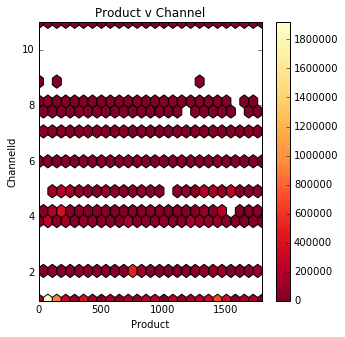

In [15]:
# create a summary table and then produce a hexbin plot (31s)
t0 = time.time()
df_summary = group_data(df_train,['ProductId','ChannelId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])

# make the product and channel ids contiguous by factorizing them
df_summary = factor_data(df_summary,[['ProductId','Product']])

# plot a hexbin with Demand as the colour density
df_summary.plot.hexbin(x='Product',y='ChannelId',C='Demand',sharex=False,
                       title='Product v Channel',figsize=(5,5),gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r)
print time.time() - t0

#### Route, Route and Product, Route and Channel

In [16]:
# we'll create all 3 summaries in one go (93s)
t0 = time.time()
df_route = group_data(df_train,['RouteId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])
df_routechannel = group_data(df_train,['RouteId','ChannelId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])
df_routeproduct = group_data(df_train,['RouteId','ProductId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])

stats = df_route.describe(percentiles=[0.25,0.5,0.75,0.99])
print stats
print time.time() - t0

           RouteId         Sales    SalesPesos        Returns  ReturnsPesos  \
count  3603.000000  3.603000e+03  3.603000e+03    3603.000000  3.603000e+03   
mean   5105.666944  1.505055e+05  1.411231e+06    2681.813489  2.559665e+04   
std    3121.264627  3.177840e+05  3.042500e+06    9343.883259  6.585252e+04   
min       1.000000  0.000000e+00  0.000000e+00       0.000000  0.000000e+00   
25%    2121.500000  4.970000e+02  9.881080e+03       0.000000  0.000000e+00   
50%    4535.000000  1.840100e+04  1.743034e+05     139.000000  1.297660e+03   
75%    8038.500000  1.401565e+05  1.339746e+06    2192.000000  2.095301e+04   
99%    9929.980000  1.577047e+06  1.586738e+07   26942.980000  2.876489e+05   
max    9991.000000  2.645921e+06  3.102652e+07  402419.000000  1.273667e+06   

             Demand  
count  3.603000e+03  
mean   1.487431e+05  
std    3.138618e+05  
min    0.000000e+00  
25%    4.970000e+02  
50%    1.818500e+04  
75%    1.383645e+05  
99%    1.562388e+06  
max    2.62

1.32400012016


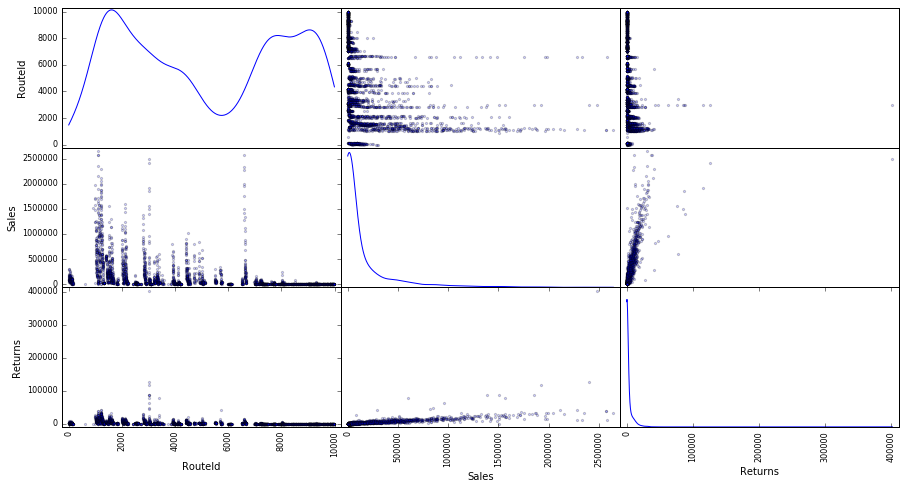

In [17]:
t0 = time.time()

# do a scatter matrix plot for the numerics
scatter_matrix(df_route[['RouteId','Sales','Returns']],alpha=0.2,diagonal='kde',figsize=(15,7.5))
print time.time() - t0

0.25200009346


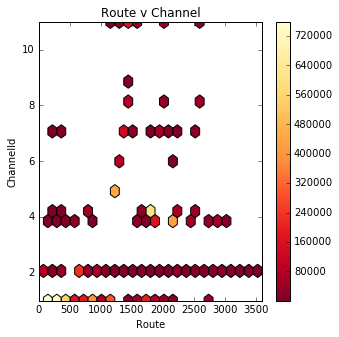

In [18]:
# factor the route ids and then produce a hexbin plot
t0 = time.time()

# make the product and channel ids contiguous by factorizing them
df_routechannel = factor_data(df_routechannel,[['RouteId','Route']])

# plot a hexbin with Sales as the colour density
df_routechannel.plot.hexbin(x='Route',y='ChannelId',C='Sales',sharex=False,
                       title='Route v Channel',figsize=(5,5),gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r)
print time.time() - t0

3.27700018883


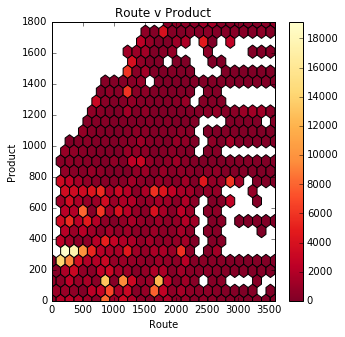

In [19]:
# factor the route and product ids and then produce a hexbin plot
t0 = time.time()

# factor the categories
df_routeproduct = factor_data(df_routeproduct,[['RouteId','Route'],['ProductId','Product']])

# plot a hexbin with Sales as the colour density
df_routeproduct.plot.hexbin(x='Route',y='Product',C='Sales',sharex=False,
                       title='Route v Product',figsize=(5,5),gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r)
print time.time() - t0

#### Agency and its relationship to product, channel and route

In [20]:
# we'll create all 4 summaries in one go (124s)
t0 = time.time()
df_agency = group_data(df_train,['AgencyId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])
df_agencychannel = group_data(df_train,['AgencyId','ChannelId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])
df_agencyproduct = group_data(df_train,['AgencyId','ProductId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])
df_agencyroute = group_data(df_train,['AgencyId','RouteId'],['Sales','SalesPesos','Returns','ReturnsPesos','Demand'])

# factorize the ids
df_agencychannel = factor_data(df_agencychannel,[['AgencyId','Agency']])
df_agencyproduct = factor_data(df_agencyproduct,[['AgencyId','Agency'],['ProductId','Product']])
df_agencyroute = factor_data(df_agencyroute,[['AgencyId','Agency'],['RouteId','Route']])

print df_agency.describe(percentiles=[0.25,0.5,0.75,0.99])
print time.time() - t0

           AgencyId         Sales    SalesPesos        Returns  ReturnsPesos  \
count    552.000000  5.520000e+02  5.520000e+02     552.000000  5.520000e+02   
mean    2410.675725  9.823756e+05  9.211349e+06   17504.663043  1.670738e+05   
std     3504.581430  9.089998e+05  8.362651e+06   21435.047724  1.952609e+05   
min     1110.000000  3.232900e+04  3.162370e+05       0.000000  0.000000e+00   
25%     1386.750000  2.873145e+05  3.098703e+06    3888.500000  3.835418e+04   
50%     1656.500000  6.365040e+05  6.728786e+06   11867.500000  1.185766e+05   
75%     2089.250000  1.432013e+06  1.308555e+07   25272.750000  2.397914e+05   
99%    23888.800000  3.674920e+06  3.163201e+07   72511.670000  7.655478e+05   
max    25759.000000  5.355617e+06  6.616379e+07  316149.000000  2.480405e+06   

             Demand  
count  5.520000e+02  
mean   9.708723e+05  
std    9.000488e+05  
min    3.197300e+04  
25%    2.817865e+05  
50%    6.300740e+05  
75%    1.418065e+06  
99%    3.647269e+06  
m

0.944999933243


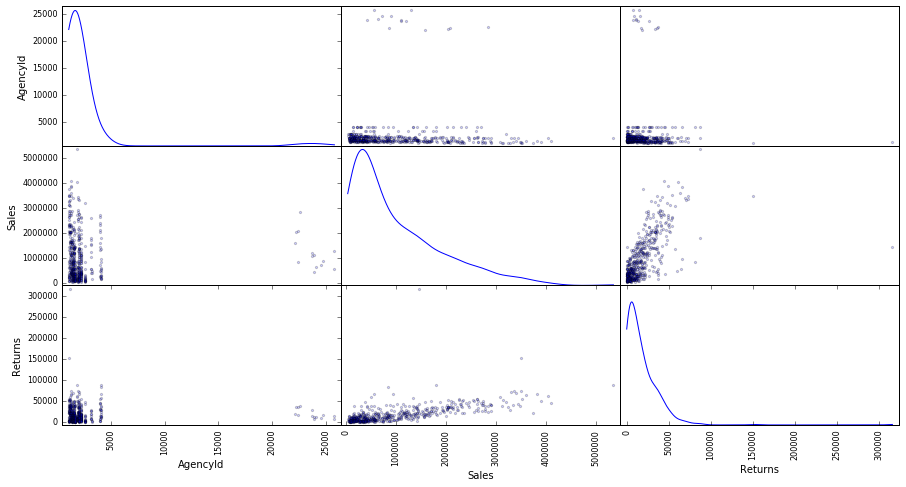

In [21]:
t0 = time.time()

# do a scatter matrix plot for the numerics (1s)
scatter_matrix(df_agency[['AgencyId','Sales','Returns']],alpha=0.2,diagonal='kde',figsize=(15,7.5))
print time.time() - t0

1.42700004578


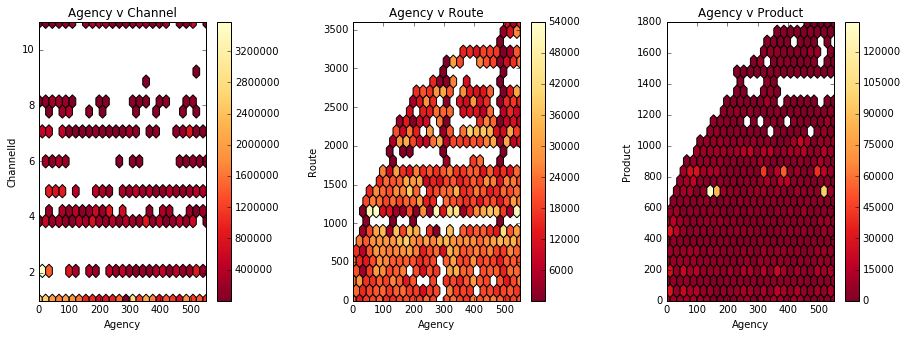

In [22]:
# factor the Ids and then produce a hexbin plot (1.5s)
t0 = time.time()

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
# plot a hexbin with Sales as the colour density
df_agencychannel.plot.hexbin(ax=axes[0],x='Agency',y='ChannelId',C='Sales',sharex=False,
                       title='Agency v Channel',gridsize=25, edgecolors=None, cmap=plt.cm.YlOrRd_r)
df_agencyroute.plot.hexbin(ax=axes[1],x='Agency',y='Route',C='Sales',sharex=False,
                       title='Agency v Route',gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r)
df_agencyproduct.plot.hexbin(ax=axes[2],x='Agency',y='Product',C='Sales',sharex=False,
                       title='Agency v Product',gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.3)

print time.time() - t0

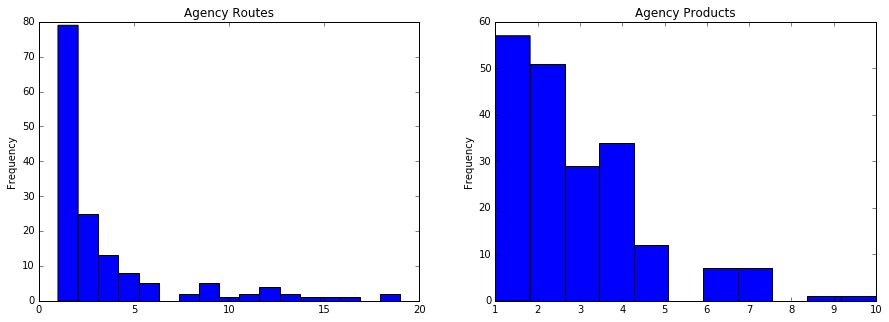

In [23]:
# looking at how many routes and products agents tend to operate 

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

df_agencyroute['AgencyId'].value_counts().value_counts().plot(bins=17,ax=axes[0],kind='hist'
                                                              ,sharex=False,title='Agency Routes')
df_agencyproduct['AgencyId'].value_counts().value_counts().plot(bins=11,ax=axes[1],kind='hist'
                                                                ,sharex=False,title='Agency Products')

#### Client
Let's look at client and its relationship with product, agency, channel and route

In [24]:
# we'll create all 5 summaries in one go (250s)
t0 = time.time()
df_client = group_data(df_train,['ClientId'],['Sales','Returns'])
df_clientchannel = group_data(df_train,['ClientId','ChannelId'],['Sales','Returns'])
df_clientproduct = group_data(df_train,['ClientId','ProductId'],['Sales','Returns'])
df_clientroute = group_data(df_train,['ClientId','RouteId'],['Sales','Returns'])
df_clientagency = group_data(df_train,['ClientId','AgencyId'],['Sales','Returns'])

df_client = factor_data(df_client,[['ClientId','Client']])
df_clientchannel = factor_data(df_clientchannel,[['ClientId','Client']])
df_clientproduct = factor_data(df_clientproduct,[['ClientId','Client'],['ProductId','Product']])
df_clientroute = factor_data(df_clientroute,[['ClientId','Client'],['RouteId','Route']])
df_clientagency = factor_data(df_clientagency,[['ClientId','Client'],['AgencyId','Agency']])

print df_client.describe(percentiles=[0.25,0.5,0.75,0.99])
print time.time() - t0

              Sales       Returns         Client
count  8.806040e+05  8.806040e+05  880604.000000
mean   6.157947e+02  1.097267e+01  440301.500000
std    1.999001e+04  1.212024e+03  254208.622563
min    0.000000e+00  0.000000e+00       0.000000
25%    8.000000e+01  0.000000e+00  220150.750000
50%    2.320000e+02  1.000000e+00  440301.500000
75%    6.040000e+02  7.000000e+00  660452.250000
99%    4.706000e+03  1.020000e+02  871796.970000
max    1.865000e+07  1.131794e+06  880603.000000
223.231000185


16.114000082


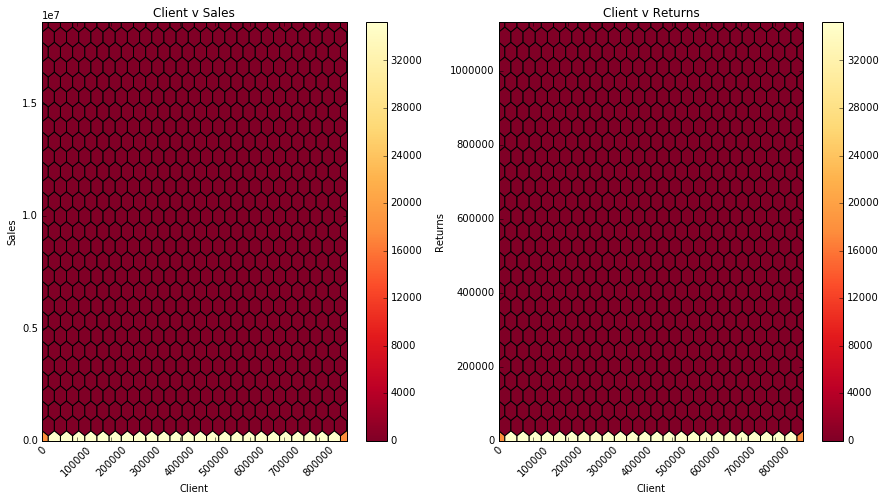

In [26]:
t0 = time.time()

# do a a set of scatters for the numerics (200-400s)
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7.5))

df_client.plot.hexbin(ax=axes[0],x='Client',y='Sales',sharex=False,title='Client v Sales'
                      ,gridsize=25, edgecolors=None, cmap=plt.cm.YlOrRd_r,rot=45)
df_client.plot.hexbin(ax=axes[1],x='Client',y='Returns',sharex=False,title='Client v Returns'
                      ,gridsize=25, edgecolors=None, cmap=plt.cm.YlOrRd_r,rot=45)

print time.time() - t0

286.519999981


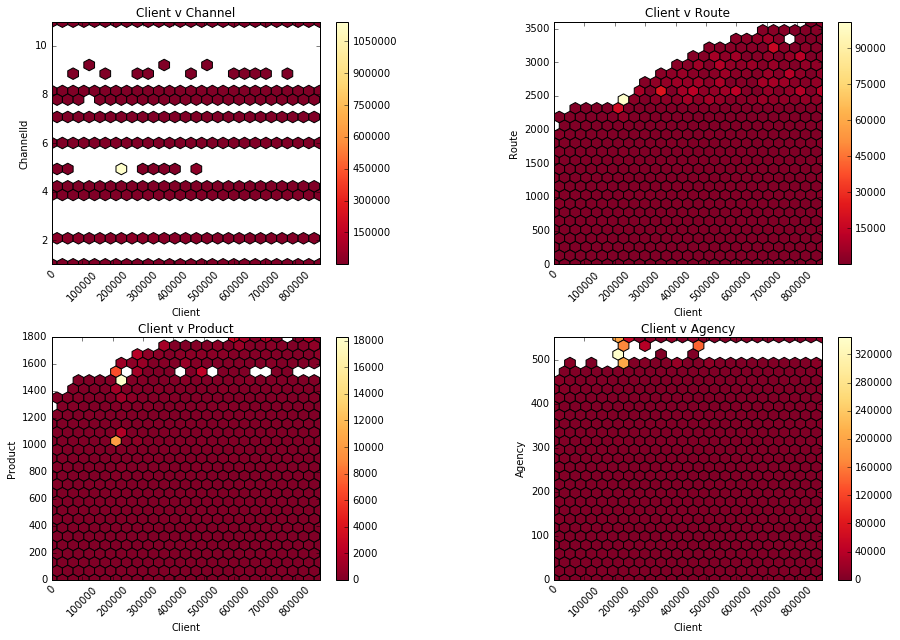

In [27]:
# produce a hexbin plot of client v all attributes with sales as color density (273s)
t0 = time.time()

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
# plot a hexbin with Sales as the colour density
df_clientchannel.plot.hexbin(ax=axes[0,0],x='Client',y='ChannelId',C='Sales',use_index=True,sharex=False,
                       title='Client v Channel',gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r,rot=45)
df_clientroute.plot.hexbin(ax=axes[0,1],x='Client',y='Route',C='Sales',use_index=True,sharex=False,
                       title='Client v Route',gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r,rot=45)
df_clientproduct.plot.hexbin(ax=axes[1,0],x='Client',y='Product',C='Sales',use_index=True,sharex=False,
                       title='Client v Product',gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r,rot=45)
df_clientagency.plot.hexbin(ax=axes[1,1],x='Client',y='Agency',C='Sales',use_index=True,sharex=False,
                       title='Client v Agency',gridsize=25, edgecolors=None,cmap=plt.cm.YlOrRd_r,rot=45)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.3)

print time.time() - t0

16.5939998627


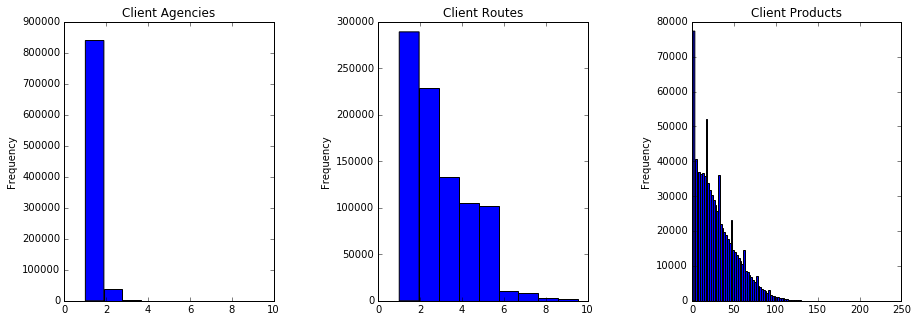

In [28]:
# let's see how many clients deal with different agencies and routes ( 20s)
t0 = time.time()
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(15,5))

df_clientagency['ClientId'].value_counts().plot(bins=69,ax=axes[0],kind='hist'
                                                                          ,sharex=False,title='Client Agencies',xlim=(0,10))
df_clientroute['ClientId'].value_counts().plot(bins=59,ax=axes[1],kind='hist'
                                                              ,sharex=False,title='Client Routes',xlim=(0,10))
df_clientproduct['ClientId'].value_counts().plot(bins=100,ax=axes[2],kind='hist'
                                                              ,sharex=False,title='Client Products')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.3)
print time.time() - t0